<h1> Regression, Transforming Target </h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from helper import (plot_exponential_data, 
                    plot_square_normal_data)

import warnings
warnings.simplefilter("ignore")

In [2]:
from helper import boston_dataframe
boston_data = boston_dataframe()

In [3]:
boston_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### Determining Normality
Making our target variable normally distributed often will lead to better results

If our target is not normally distributed, we can apply a transformation to it and then fit our regression to predict the transformed values.

How can we tell if our target is normally distributed? There are two ways:

<li>Visually</li>
<li>Using a statistical test</li>

##### Visually 

Plotting a histogram:

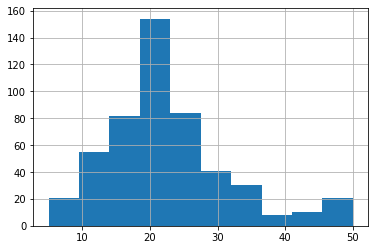

In [8]:
boston_data.MEDV.hist();

Does not look normal due to that right tail. Let's try to verify statistically:

In [9]:
from scipy.stats.mstats import normaltest # D'Agostino K^2 Test

In [10]:
normaltest(boston_data.MEDV.values)

NormaltestResult(statistic=90.9746873700967, pvalue=1.7583188871696095e-20)

p-value extremely low. Our y variable we've been dealing with this whole time was not normally distributed!

<h3> Testing log </h3>

In [11]:
log_medv = np.log(boston_data.MEDV)

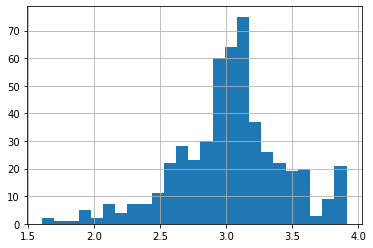

In [12]:
log_medv.hist(bins=25);

In [13]:
normaltest(log_medv)

NormaltestResult(statistic=17.21801696640697, pvalue=0.00018245472768345307)

Conclusion: closer, but still not normal.

<h3> Square root transformation </h3>

(array([  9.,  18.,  40.,  67., 131., 121.,  48.,  36.,  10.,  26.]),
 array([2.23606798, 2.71956796, 3.20306794, 3.68656793, 4.17006791,
        4.65356789, 5.13706788, 5.62056786, 6.10406784, 6.58756783,
        7.07106781]),
 <a list of 10 Patch objects>)

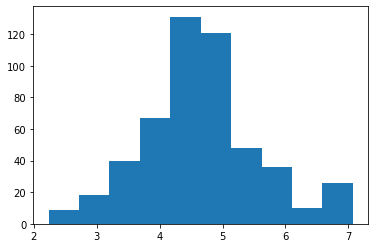

In [15]:
sqrt_medv = np.sqrt(boston_data.MEDV)
plt.hist(sqrt_medv)

In [16]:
normaltest(sqrt_medv)

NormaltestResult(statistic=20.487090826863067, pvalue=3.558645701429252e-05)

<h3> Box cox transformation </h3>

The box cox transformation is a parametrized transformation that tries to get distributions "as close to a normal distribution as possible".

It is defined as:

$$ \text{boxcox}(y_i) = \frac{y_i^{\lambda} - 1}{\lambda} $$

You can think of as a generalization of the square root function: the square root function uses the exponent of 0.5, but box cox lets its exponent vary so it can find the best one.

In [19]:
from scipy.stats import boxcox

In [20]:
bc_result = boxcox(boston_data.MEDV)
boxcox_medv = bc_result[0]
lam = bc_result[1]

In [21]:
lam

0.2166209012915364

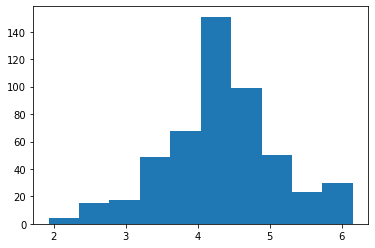

In [26]:
plt.hist(boxcox_medv);

In [27]:
normaltest(boxcox_medv)

NormaltestResult(statistic=4.513528775533045, pvalue=0.1046886692817602)

Significantly more normally distributed (according to p value) than the other two distributions - above 0.05, even!

Now that we have a normally distributed y-variable, let's try a regression!

### Testing Regression

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler, 
                                   PolynomialFeatures)

In [30]:
lr = LinearRegression()

#### Reload clean version of boston data

In [31]:
boston_data = boston_dataframe()

#### Create X and y

In [32]:
y_col = "MEDV"

X = boston_data.drop(y_col, axis=1)
y = boston_data[y_col]

#### Create Polynomial features

In [44]:
pf = PolynomialFeatures(degree=2, include_bias=False)
X_pf = pf.fit_transform(X)

#### Train test split

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_pf, y, test_size=0.3, 
                                                    random_state=72018)

#### Fit StandardScaler on X_train as before

In [35]:
s = StandardScaler()
X_train_s = s.fit_transform(X_train)

#### Apply the appropriate transformation.

In [53]:
# Instructor Solution
bc_result2 = boxcox(y_train)
y_train_bc = bc_result2[0]
lam2 = bc_result2[1]

In [54]:
y_train_bc.shape

(354,)

In [80]:
lr.fit(X_train_s, y_train_bc)
X_test_s = s.transform(X_test)
y_pred_bc = lr.predict(X_test_s)

#### Inverse transformation

Every transformation has an inverse transformation. The inverse transformation of  𝑓(𝑥)=𝑥⎯⎯√  is  𝑓−1(𝑥)=𝑥2 , for example. Box cox has an inverse transformation as well: notice that we have to pass in the lambda value that we found from before:

In [81]:
from scipy.special import inv_boxcox

In [82]:
y_pred_bc = inv_boxcox(y_pred_bc, lam)

#### Model Validation

In [85]:
from sklearn.metrics import mean_absolute_error

In [86]:
mean_absolute_error(y_test, y_pred_bc)

6.80611370408036